In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy.stats
from statistics import mean
from statistics import stdev

from collections import Counter
import warnings # Turn off warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, precision_score, recall_score, accuracy_score, precision_recall_curve, confusion_matrix

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from ipywidgets import interactive, FloatSlider
from sklearn.externals.six import StringIO
from sklearn.tree import export_graphviz
from IPython.display import Image
import pydotplus

In [2]:
def make_confusion_matrix(model, threshold=0.5):
    """
    Predict class1 if probability of being in class 1 is greater than threshold
    """
    y_predict = (model.predict_proba(features_test_scaled_array)[:, 1] >= threshold)
    confusion = confusion_matrix(target_test_ser, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(confusion, cmap='YlGn', annot=True, square=True, fmt='d',
           xticklabels=['Rejected', 'Accepted'],
           yticklabels=['Rejected', 'Accepted']);
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('Actual', fontsize=12)
    plt.title('Confusion Matrix for Random Forest', fontsize=16);
    #plt.savefig("Figures/Heatmap.png", transparent=False, bbox_inches="tight")

In [3]:
# Import
physics_df = pd.read_csv('Data/physics_ft_df.csv')
physics_df = physics_df.drop(columns = ["Unnamed: 0"])
print(physics_df.columns)

Index(['GPA', 'GRE_Verbal', 'GRE_Quantitative', 'GRE_Writing', 'GRE_Subject',
       'American', 'Papers', 'Research', 'Decision', 'GPA_rev',
       'GRE_Verbal_rev', 'GRE_Quantitative_rev', 'GRE_Writing_rev',
       'GRE_Subject_rev', 'Decision_rev', 'GPA_log', 'GRE_Verbal_log',
       'GRE_Quantitative_log', 'GRE_Writing_log', 'GRE_Subject_log', 'GPA_sq',
       'GRE_Verbal_sq', 'GRE_Quantitative_sq', 'GRE_Writing_sq',
       'GRE_Subject_sq', 'GRE_Verbal_pc', 'GRE_Quantitative_pc',
       'GRE_Writing_pc', 'GRE_Subject_pc', 'GREVxGREQ', 'GREVxGRES',
       'GREQxGRES', 'GREVxGREQxGRES'],
      dtype='object')


In [4]:
# Used for K-fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state = 71)
scaler = StandardScaler()
ros = RandomOverSampler(random_state=0)

# For comparing models at the end of the notebook
models_list = ['GaussianNB', 'Logistic Regression', 'SVC', 'XGBoost', 'Random Forest']
cv_roc_auc_score_list = []
cv_roc_auc_error_list = []

In [5]:
# Set aside 20% of data for final test
features_train_all_df, features_test_all_df, target_train_ser, target_test_ser = train_test_split(physics_df.drop(columns = ['Decision']), physics_df['Decision'], test_size=.2, random_state=42)

# Select Features
features_list = ['GPA', 'GPA_sq', 'GRE_Verbal', 'GRE_Quantitative', 'GRE_Writing_pc', 'GRE_Subject', 'GREVxGRES', 'American', 'Papers', 'Research']
features_train_chosen_df = features_train_all_df[features_list]
features_test_chosen_df = features_test_all_df[features_list]
features_train_chosen_array = np.array(features_train_chosen_df)
target_train_array = np.array(target_train_ser)

val_f1_score:  0.584506248694417  +/-  0.023233431493650657
val_roc_auc_score:  0.6014864766716054  +/-  0.0216947319002287
test f1 score =  0.6010050251256281
test ROC AUC score =  0.6149789231195695
test accuracy score =  0.566120218579235


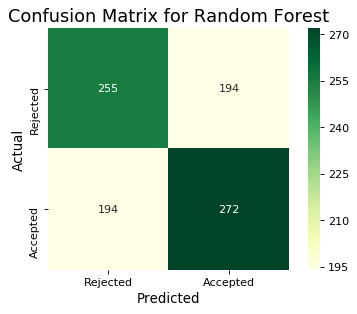

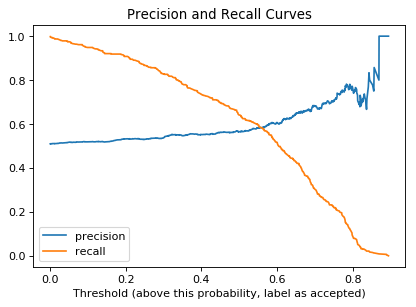

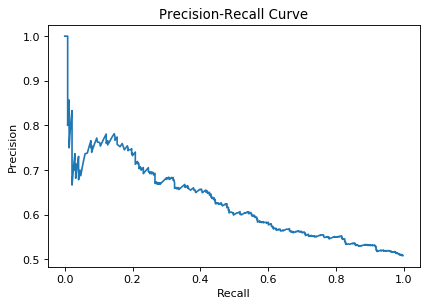

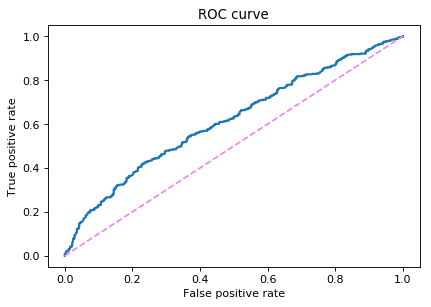

In [6]:
# Gaussian Naive Bayes
gnb_clf = GaussianNB()

# Collect the cross-validation results
cv_f1_list, roc_auc_list = [], []

for train_index, val_cv_index in kf.split(features_train_chosen_array, target_train_array):
    
    # Make the split
    features_train_cv_array, target_train_cv_array = features_train_chosen_array[train_index], target_train_array[train_index]
    features_val_cv_array, target_val_cv_array = features_train_chosen_array[val_cv_index], target_train_array[val_cv_index] 
    
    # Rebalance train features, no need to rebalance validation set, resample is better than smote
    features_train_cv_resampled_array, target_train_cv_resampled_array = ros.fit_sample(features_train_cv_array, target_train_cv_array)
    features_train_cv_resampled_scaled_array = scaler.fit_transform(features_train_cv_resampled_array)  # Scale resampled features
    features_val_cv_scaled_array = scaler.transform(features_val_cv_array)  # Scale validation features
    
    gnb_clf.fit(features_train_cv_resampled_scaled_array, target_train_cv_resampled_array) # Fit model
    cv_f1_list.append(f1_score(gnb_clf.predict(features_val_cv_scaled_array), target_val_cv_array)) # Collect results
    roc_auc_list.append(roc_auc_score(target_val_cv_array, gnb_clf.predict_proba(features_val_cv_scaled_array)[:,1])) # Collect results

print('val_f1_score: ', mean(cv_f1_list),' +/- ', stdev(cv_f1_list))
print('val_roc_auc_score: ', mean(roc_auc_list),' +/- ', stdev(roc_auc_list))

cv_roc_auc_score_list.append(mean(roc_auc_list))
cv_roc_auc_error_list.append(stdev(roc_auc_list))

# Final train and test

# Rebalance train features, no need to rebalance validation set, resample is better than smote
features_train_resampled_array, target_train_resampled_array = ros.fit_sample(features_train_chosen_array, target_train_array)
features_train_resampled_scaled_array = scaler.fit_transform(features_train_resampled_array) # Scale features
features_test_scaled_array = scaler.transform(features_test_chosen_df) # Scale features

gnb_clf.fit(features_train_resampled_scaled_array, target_train_resampled_array) # Fit model
gnb_fpr, gnb_tpr, gnb_thresholds = roc_curve(target_test_ser, gnb_clf.predict_proba(features_test_scaled_array)[:,1]) # For later

print("test f1 score = ", f1_score(gnb_clf.predict(features_test_scaled_array), target_test_ser))
print("test ROC AUC score = ", roc_auc_score(target_test_ser, gnb_clf.predict_proba(features_test_scaled_array)[:,1]))
print("test accuracy score = ", accuracy_score(target_test_ser, gnb_clf.predict(features_test_scaled_array)))

make_confusion_matrix(gnb_clf, threshold=0.56)

# Precision and recall curve
precision_curve, recall_curve, threshold_curve = precision_recall_curve(target_test_ser, gnb_clf.predict_proba(features_test_scaled_array)[:,1])
plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as accepted)');
plt.title('Precision and Recall Curves');

# Precision-recall curve
plt.figure(dpi=80)
plt.plot(recall_curve[1:], precision_curve[1:],label='precision')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve");

# ROC Curve
fpr, tpr, thresholds = roc_curve(target_test_ser, gnb_clf.predict_proba(features_test_scaled_array)[:,1])
plt.figure(dpi=80)
plt.plot(fpr, tpr, lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');

val_f1_score:  0.5552797449722199  +/-  0.02337271702724355
val_roc_auc_score:  0.6059809943802167  +/-  0.015010870727332381
test f1 score =  0.5767543859649122
test ROC AUC score =  0.6153636598258408


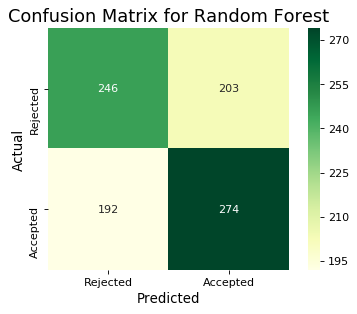

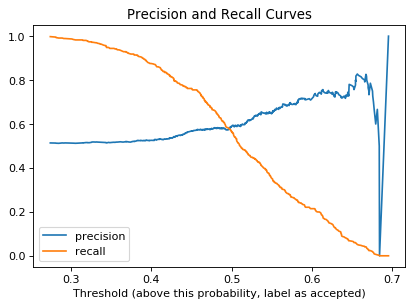

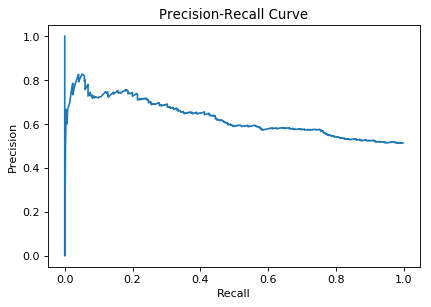

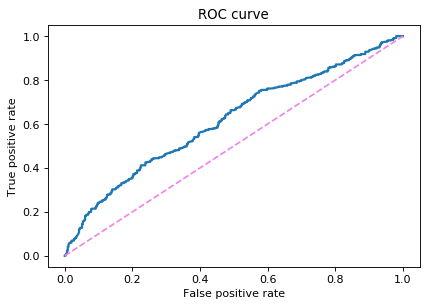

In [7]:
# Logistic Regression
logreg_clf = LogisticRegression(C=1e9)

# Collect the cross-validation results
cv_f1_list, roc_auc_list = [], []

for train_index, val_cv_index in kf.split(features_train_chosen_array, target_train_array):
    
    # Make the split
    features_train_cv_array, target_train_cv_array = features_train_chosen_array[train_index], target_train_array[train_index]
    features_val_cv_array, target_val_cv_array = features_train_chosen_array[val_cv_index], target_train_array[val_cv_index] 
    
    # Rebalance train features, no need to rebalance validation set, resample is better than smote
    features_train_cv_resampled_array, target_train_cv_resampled_array = ros.fit_sample(features_train_cv_array, target_train_cv_array)
    features_train_cv_resampled_scaled_array = scaler.fit_transform(features_train_cv_resampled_array)  # Scale resampled features
    features_val_cv_scaled_array = scaler.transform(features_val_cv_array)  # Scale validation features
    
    logreg_clf.fit(features_train_cv_resampled_scaled_array, target_train_cv_resampled_array) # Fit model
    cv_f1_list.append(f1_score(logreg_clf.predict(features_val_cv_scaled_array), target_val_cv_array)) # Collect results
    roc_auc_list.append(roc_auc_score(target_val_cv_array, logreg_clf.predict_proba(features_val_cv_scaled_array)[:,1])) # Collect results

print('val_f1_score: ', mean(cv_f1_list),' +/- ', stdev(cv_f1_list))
print('val_roc_auc_score: ', mean(roc_auc_list),' +/- ', stdev(roc_auc_list))

cv_roc_auc_score_list.append(mean(roc_auc_list))
cv_roc_auc_error_list.append(stdev(roc_auc_list))

# Final train and test

# Rebalance train features, no need to rebalance validation set, resample is better than smote
features_train_resampled_array, target_train_resampled_array = ros.fit_sample(features_train_chosen_array, target_train_array)
features_train_resampled_scaled_array = scaler.fit_transform(features_train_resampled_array) # Scale features
features_test_scaled_array = scaler.transform(features_test_chosen_df) # Scale features

logreg_clf.fit(features_train_resampled_scaled_array, target_train_resampled_array) # Fit model
logreg_fpr, logreg_tpr, logreg_thresholds = roc_curve(target_test_ser, logreg_clf.predict_proba(features_test_scaled_array)[:,1]) # For later

print("test f1 score = ", f1_score(logreg_clf.predict(features_test_scaled_array), target_test_ser))
print("test ROC AUC score = ", roc_auc_score(target_test_ser, logreg_clf.predict_proba(features_test_scaled_array)[:,1]))
#print("test accuracy score = ", accuracy_score(target_test_ser, logreg_clf_clf.predict(features_test_scaled_array)))

make_confusion_matrix(logreg_clf, threshold=0.493)

# Precision and recall curve
precision_curve, recall_curve, threshold_curve = precision_recall_curve(target_test_ser, logreg_clf.predict_proba(features_test_scaled_array)[:,1])
plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as accepted)');
plt.title('Precision and Recall Curves');

# Precision-recall curve
plt.figure(dpi=80)
plt.plot(recall_curve[1:], precision_curve[1:],label='precision')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve");

# ROC Curve
fpr, tpr, thresholds = roc_curve(target_test_ser, logreg_clf.predict_proba(features_test_scaled_array)[:,1])
plt.figure(dpi=80)
plt.plot(fpr, tpr, lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');

val_f1_score:  0.5637136978078665  +/-  0.024872340386431706
val_roc_auc_score:  0.6200946339703509  +/-  0.015141768203140869
test f1 score =  0.5887541345093716
test ROC AUC score =  0.6352480954338204
test accuracy score =  0.5923497267759563


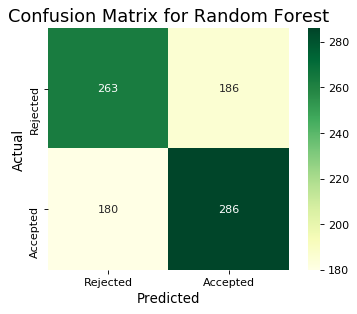

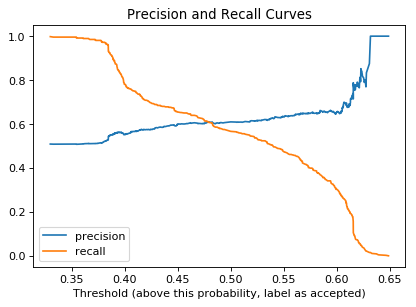

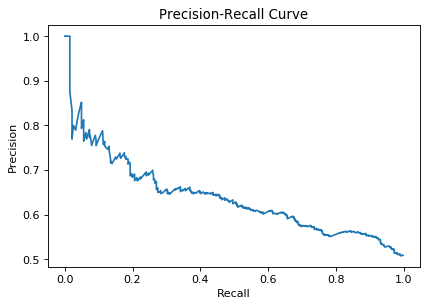

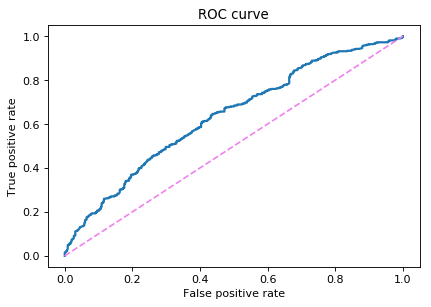

In [8]:
# Support Vector Machines
svc_clf = SVC(probability=True, class_weight = 'balanced')

# Collect the cross-validation results
cv_f1_list, roc_auc_list = [], []

for train_index, val_cv_index in kf.split(features_train_chosen_array, target_train_array):
    
    # Make the split
    features_train_cv_array, target_train_cv_array = features_train_chosen_array[train_index], target_train_array[train_index]
    features_val_cv_array, target_val_cv_array = features_train_chosen_array[val_cv_index], target_train_array[val_cv_index] 
    
    # Rebalance train features, no need to rebalance validation set, resample is better than smote
    features_train_cv_resampled_array, target_train_cv_resampled_array = ros.fit_sample(features_train_cv_array, target_train_cv_array)
    features_train_cv_resampled_scaled_array = scaler.fit_transform(features_train_cv_resampled_array)  # Scale resampled features
    features_val_cv_scaled_array = scaler.transform(features_val_cv_array)  # Scale validation features
    
    svc_clf.fit(features_train_cv_resampled_scaled_array, target_train_cv_resampled_array) # Fit model
    cv_f1_list.append(f1_score(svc_clf.predict(features_val_cv_scaled_array), target_val_cv_array)) # Collect results
    roc_auc_list.append(roc_auc_score(target_val_cv_array, svc_clf.predict_proba(features_val_cv_scaled_array)[:,1])) # Collect results

print('val_f1_score: ', mean(cv_f1_list),' +/- ', stdev(cv_f1_list))
print('val_roc_auc_score: ', mean(roc_auc_list),' +/- ', stdev(roc_auc_list))

cv_roc_auc_score_list.append(mean(roc_auc_list))
cv_roc_auc_error_list.append(stdev(roc_auc_list))

# Final train and test

# Rebalance train features, no need to rebalance validation set, resample is better than smote
features_train_resampled_array, target_train_resampled_array = ros.fit_sample(features_train_chosen_array, target_train_array)
features_train_resampled_scaled_array = scaler.fit_transform(features_train_resampled_array) # Scale features
features_test_scaled_array = scaler.transform(features_test_chosen_df) # Scale features

svc_clf.fit(features_train_resampled_scaled_array, target_train_resampled_array) # Fit model
svc_fpr, svc_tpr, svc_thresholds = roc_curve(target_test_ser, svc_clf.predict_proba(features_test_scaled_array)[:,1]) # For later

print("test f1 score = ", f1_score(svc_clf.predict(features_test_scaled_array), target_test_ser))
print("test ROC AUC score = ", roc_auc_score(target_test_ser, svc_clf.predict_proba(features_test_scaled_array)[:,1]))
print("test accuracy score = ", accuracy_score(target_test_ser, svc_clf.predict(features_test_scaled_array)))

# Confusion Matrix
make_confusion_matrix(svc_clf, threshold = 0.477)

# Precision and recall curve
precision_curve, recall_curve, threshold_curve = precision_recall_curve(target_test_ser, svc_clf.predict_proba(features_test_scaled_array)[:,1])
plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as accepted)');
plt.title('Precision and Recall Curves');

# Precision-recall curve
plt.figure(dpi=80)
plt.plot(recall_curve[1:], precision_curve[1:],label='precision')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve");

# ROC Curve
fpr, tpr, thresholds = roc_curve(target_test_ser, svc_clf.predict_proba(features_test_scaled_array)[:,1])
plt.figure(dpi=80)
plt.plot(fpr, tpr, lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');

val_f1_score:  0.5610935084335227  +/-  0.029446340692465843
val_roc_auc_score:  0.6249185134968548  +/-  0.01834475241873732
test f1 score =  0.5832426550598476
test ROC AUC score =  0.6430670923463682
test accuracy score =  0.5814207650273224


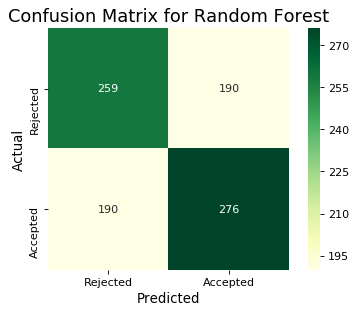

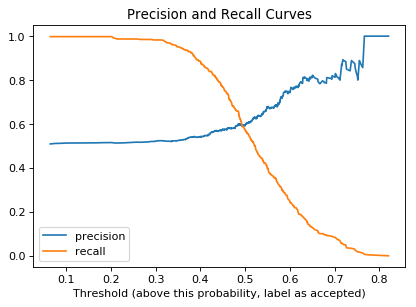

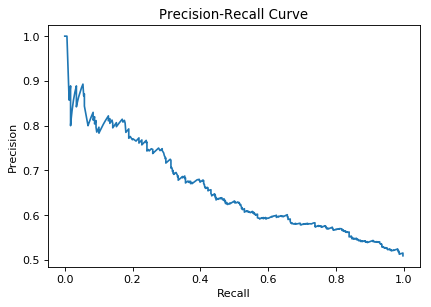

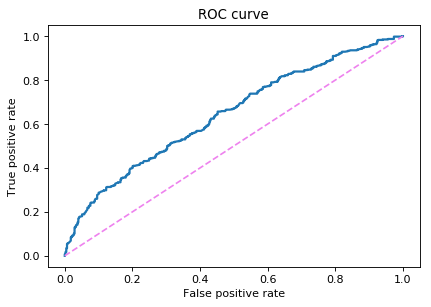

In [9]:
# XGBoost
xgb_clf = XGBClassifier()

# Collect the cross-validation results
cv_f1_list, roc_auc_list = [], []

for train_index, val_cv_index in kf.split(features_train_chosen_array, target_train_array):
    
    # Make the split
    features_train_cv_array, target_train_cv_array = features_train_chosen_array[train_index], target_train_array[train_index]
    features_val_cv_array, target_val_cv_array = features_train_chosen_array[val_cv_index], target_train_array[val_cv_index] 
    
    # Rebalance train features, no need to rebalance validation set, resample is better than smote
    features_train_cv_resampled_array, target_train_cv_resampled_array = ros.fit_sample(features_train_cv_array, target_train_cv_array)
    features_train_cv_resampled_scaled_array = scaler.fit_transform(features_train_cv_resampled_array)  # Scale resampled features
    features_val_cv_scaled_array = scaler.transform(features_val_cv_array)  # Scale validation features
    
    xgb_clf.fit(features_train_cv_resampled_scaled_array, target_train_cv_resampled_array) # Fit model
    cv_f1_list.append(f1_score(xgb_clf.predict(features_val_cv_scaled_array), target_val_cv_array)) # Collect results
    roc_auc_list.append(roc_auc_score(target_val_cv_array, xgb_clf.predict_proba(features_val_cv_scaled_array)[:,1])) # Collect results

print('val_f1_score: ', mean(cv_f1_list),' +/- ', stdev(cv_f1_list))
print('val_roc_auc_score: ', mean(roc_auc_list),' +/- ', stdev(roc_auc_list))

cv_roc_auc_score_list.append(mean(roc_auc_list))
cv_roc_auc_error_list.append(stdev(roc_auc_list))

# Final train and test

# Rebalance train features, no need to rebalance validation set, resample is better than smote
features_train_resampled_array, target_train_resampled_array = ros.fit_sample(features_train_chosen_array, target_train_array)
features_train_resampled_scaled_array = scaler.fit_transform(features_train_resampled_array) # Scale features
features_test_scaled_array = scaler.transform(features_test_chosen_df) # Scale features

xgb_clf.fit(features_train_resampled_scaled_array, target_train_resampled_array) # Fit model
xgb_fpr, xgb_tpr, xgb_thresholds = roc_curve(target_test_ser, xgb_clf.predict_proba(features_test_scaled_array)[:,1]) # For later

print("test f1 score = ", f1_score(xgb_clf.predict(features_test_scaled_array), target_test_ser))
print("test ROC AUC score = ", roc_auc_score(target_test_ser, xgb_clf.predict_proba(features_test_scaled_array)[:,1]))
print("test accuracy score = ", accuracy_score(target_test_ser, xgb_clf.predict(features_test_scaled_array)))

# Confusion Matrix
make_confusion_matrix(xgb_clf, threshold = 0.4929)

# Precision and recall curve
precision_curve, recall_curve, threshold_curve = precision_recall_curve(target_test_ser, xgb_clf.predict_proba(features_test_scaled_array)[:,1])
plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as accepted)');
plt.title('Precision and Recall Curves');

# Precision-recall curve
plt.figure(dpi=80)
plt.plot(recall_curve[1:], precision_curve[1:],label='precision')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve");

# ROC Curve
fpr, tpr, thresholds = roc_curve(target_test_ser, xgb_clf.predict_proba(features_test_scaled_array)[:,1])
plt.figure(dpi=80)
plt.plot(fpr, tpr, lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');

In [10]:
# Choose features. These are better specifically for random forest, which is insensitive to duplicated/derived features
features_list = ['GPA', 'GRE_Verbal', 'GRE_Quantitative', 'GRE_Writing_pc', 'GRE_Subject', 'American', 'Papers', 'Research']
features_train_chosen_df = features_train_all_df[features_list]
features_test_chosen_df = features_test_all_df[features_list]
features_train_chosen_array = np.array(features_train_chosen_df)
target_train_array = np.array(target_train_ser)

val_f1_score:  0.5762512783788947  +/-  0.023708502326406474
val_roc_auc_score:  0.6518194681025349  +/-  0.027469245876652264
test f1 score =  0.6276715410573678
test ROC AUC score =  0.7015542407065773
test accuracy score =  0.6382513661202186


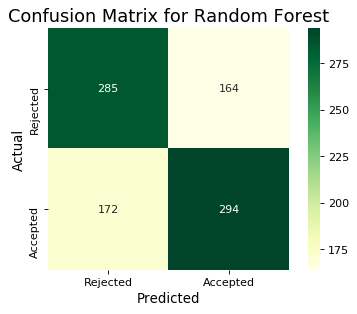

In [11]:
# Random Forest
rf_clf = RandomForestClassifier(random_state = 70)

# Collect the cross-validation results
cv_f1_list, roc_auc_list = [], []

for train_index, val_cv_index in kf.split(features_train_chosen_array, target_train_array):

    # Make the split
    features_train_cv_array, target_train_cv_array = features_train_chosen_array[train_index], target_train_array[train_index]
    features_val_cv_array, target_val_cv_array = features_train_chosen_array[val_cv_index], target_train_array[val_cv_index] 
    
    # Rebalance train features, no need to rebalance validation set, resample is better than smote
    features_train_cv_resampled_array, target_train_cv_resampled_array = ros.fit_sample(features_train_cv_array, target_train_cv_array)
    features_train_cv_resampled_scaled_array = scaler.fit_transform(features_train_cv_resampled_array)  # Scale resampled features
    features_val_cv_scaled_array = scaler.transform(features_val_cv_array)  # Scale validation features

    rf_clf.fit(features_train_cv_resampled_scaled_array, target_train_cv_resampled_array) # Fit model
    cv_f1_list.append(f1_score(rf_clf.predict(features_val_cv_scaled_array), target_val_cv_array)) # Collect results
    roc_auc_list.append(roc_auc_score(target_val_cv_array, rf_clf.predict_proba(features_val_cv_scaled_array)[:,1])) # Collect results

print('val_f1_score: ', mean(cv_f1_list),' +/- ', stdev(cv_f1_list))
print('val_roc_auc_score: ', mean(roc_auc_list),' +/- ', stdev(roc_auc_list))

cv_roc_auc_score_list.append(mean(roc_auc_list))
cv_roc_auc_error_list.append(stdev(roc_auc_list))

rf_clf = RandomForestClassifier(random_state = 70)

# Final train and test

# Rebalance train features, no need to rebalance validation set, resample is better than smote
features_train_resampled_array, target_train_resampled_array = ros.fit_sample(features_train_chosen_array, target_train_array)
features_train_resampled_scaled_array = scaler.fit_transform(features_train_resampled_array) # Scale features
features_test_scaled_array = scaler.transform(features_test_chosen_df) # Scale features

rf_clf.fit(features_train_resampled_scaled_array, target_train_resampled_array) # Fit model
rf_fpr, rf_tpr, rf_thresholds = roc_curve(target_test_ser, rf_clf.predict_proba(features_test_scaled_array)[:,1]) # For later

print("test f1 score = ", f1_score(rf_clf.predict(features_test_scaled_array), target_test_ser))
print("test ROC AUC score = ", roc_auc_score(target_test_ser, rf_clf.predict_proba(features_test_scaled_array)[:,1]))
print("test accuracy score = ", accuracy_score(target_test_ser, rf_clf.predict(features_test_scaled_array)))

# Confusion Matrix
make_confusion_matrix(rf_clf, threshold = 0.477)

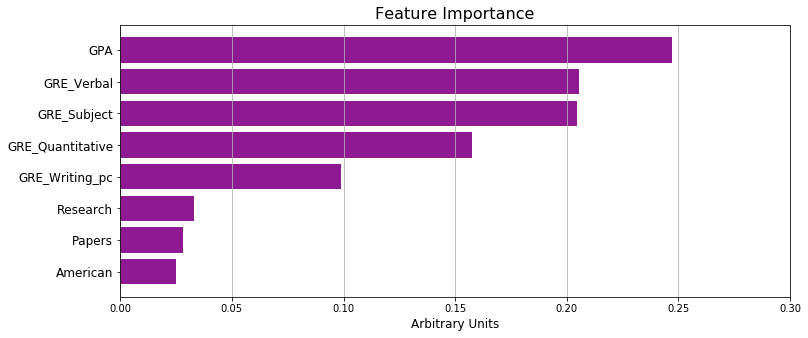

In [12]:
# Get feature importances

rf_important_features_list = list(zip(features_train_chosen_df.columns, rf_clf.feature_importances_))
rf_important_features_dict = dict(sorted(rf_important_features_list, key=lambda x: x[1], reverse = True))
features_list = list(rf_important_features_dict.keys())
importance_list = list(rf_important_features_dict.values())

y_pos = np.arange(len(features_list))

fig, ax = plt.subplots(figsize=(12, 5))
ax.barh(y_pos, importance_list[::-1], align='center', color = '#8d1a93', capsize=3)
ax.set_xlabel('Arbitrary Units', fontsize=12)
ax.set_xlim(left = 0, right = 0.3)
ax.set_yticks(y_pos)
ax.set_yticklabels(features_list[::-1], fontsize=12)
ax.set_title('Feature Importance', fontsize=16)
ax.xaxis.grid(True)
#plt.savefig("Figures/Feature Importance.png", transparent=False, bbox_inches="tight")

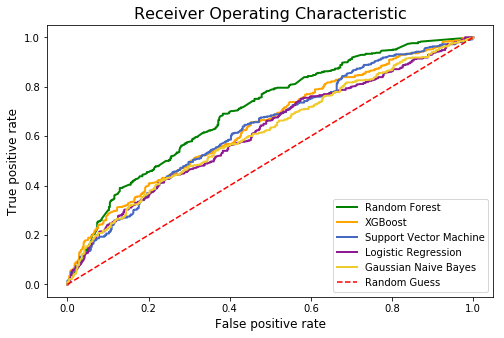

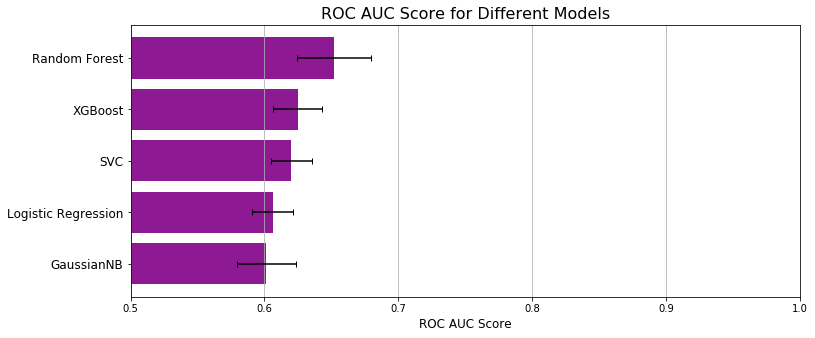

In [13]:
# Compare models

plt.subplots(figsize=(8, 5))
plt.plot(rf_fpr, rf_tpr, lw=2, color='green', label='Random Forest')
plt.plot(xgb_fpr, xgb_tpr, lw=2, color='#ffa500', label='XGBoost')
plt.plot(svc_fpr, svc_tpr, lw=2, color='#4568c2', label='Support Vector Machine')
plt.plot(logreg_fpr, logreg_tpr, lw=2, color='#8d1a93', label='Logistic Regression')
plt.plot(gnb_fpr, gnb_tpr, lw=2, color='#f0cb2f', label='Gaussian Naive Bayes')
plt.plot([0,1],[0,1],c='red',ls='--', label='Random Guess')

plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False positive rate', fontsize=12)
plt.ylabel('True positive rate', fontsize=12)
plt.legend(loc='lower right')
plt.title('Receiver Operating Characteristic', fontsize=16);
#plt.savefig("Figures/ROC.png", transparent=False, bbox_inches="tight")
plt.show()

y_pos = np.arange(len(models_list))

fig, ax = plt.subplots(figsize=(12, 5))
ax.barh(y_pos, cv_roc_auc_score_list[0:5], xerr=cv_roc_auc_error_list[0:5], align='center', color = '#8d1a93', capsize=3)
ax.set_xlabel('ROC AUC Score', fontsize=12)
ax.set_xlim(left = 0.5, right = 1)
ax.set_yticks(y_pos)
ax.set_yticklabels(models_list, fontsize=12)
ax.set_title('ROC AUC Score for Different Models', fontsize=16)
ax.xaxis.grid(True)
#plt.savefig("Figures/ROC Bar Chart.png", transparent=False, bbox_inches="tight")